In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import mariadb
import sys

import os
from dotenv import load_dotenv


### Conexão com o banco de dados

In [160]:
class DBConnection:
    @staticmethod
    def getConnection():
        load_dotenv(override=True)
        try:
            conn = mariadb.connect(
                user=os.environ['DATABASE_USERNAME'],
                password=os.environ['DATABASE_PASSWORD'],
                host=os.environ['HOST_CONNECT'],
                port=int(os.environ['DATABASE_PORT']),
                database=os.environ['DATABASE_NAME']

            )
        except mariadb.Error as e:
            print(f"Error connecting to MariaDB Platform: {e}")
            sys.exit(1)
            
        return conn.cursor(dictionary=True)

conn = DBConnection.getConnection()


### NPS dos produtos

In [62]:
conn.execute("""
    SELECT wp_posts.post_title, AVG(wp_commentmeta.meta_value) as nps FROM wp_posts
    INNER JOIN wp_comments ON wp_posts.ID = wp_comments.comment_post_ID
    INNER JOIN wp_commentmeta ON wp_comments.comment_ID = wp_commentmeta.comment_id
    WHERE
    wp_commentmeta.meta_key = 'rating'
    GROUP BY wp_posts.post_title
    ORDER BY nps DESC
""")

nps = pd.DataFrame(conn.fetchall())

### Médias

In [66]:
conn.execute("""
    SELECT AVG(total_sales) FROM wp_wc_order_stats
""")

ticket_medio = pd.DataFrame(conn.fetchall())

conn.execute("""
    SELECT AVG(num_items_sold) FROM wp_wc_order_stats
""")

media_itens_carrinho = pd.DataFrame(conn.fetchall())

### Churn

#### Churn mensal

O Churn mensal da unidade pode ser calculado da seguinte forma:

C = CP / TCMA

1. CP é a quantidade de clientes perdidos
2. TCMA é o total de clientes no mês anterior
3. C é o Churn

Vamos considerar como um cliente perdido aquele que não teve nenhuma interação com organização em 24 meses

In [181]:
from datetime import datetime

primeiro_dia_mes = datetime.today().strftime('%Y-%m') + "-01"

ano_atual = datetime.today().strftime('%Y')
dois_anos_atras = str(int(ano_atual) - 2) + "-" + datetime.today().strftime('%m-%d')

qt_novos_clientes_mes_anterior = conn.execute("""
    SELECT
        count(*) as qt
    FROM wp_users
    INNER JOIN wp_wc_customer_lookup ON wp_users.ID = wp_wc_customer_lookup.user_id
    WHERE user_registered >= %s
""", [primeiro_dia_mes])

qt_novos_clientes_mes_anterior = pd.DataFrame(conn.fetchall())

# qt_clientes_perdios = conn.execute("""
#     SELECT
#         count(*) - 1 as qt, 
#         wp_users.user_email, 
#         wp_wc_customer_lookup.date_last_active
#     FROM wp_users
#     LEFT JOIN wp_wc_customer_lookup ON wp_wc_customer_lookup.user_id = wp_users.ID
#     LEFT JOIN wp_wc_order_product_lookup ON wp_wc_customer_lookup.customer_id = wp_wc_order_product_lookup.customer_id  
#     GROUP BY wp_users.user_email
# """)

qt_clientes_perdios = conn.execute("""
    SELECT
        count(*) as qt
    FROM wp_wc_customer_lookup
    WHERE wp_wc_customer_lookup.date_last_active < %s
""", [dois_anos_atras])

qt_clientes_perdios = pd.DataFrame(conn.fetchall())

churn_mensal = qt_clientes_perdios['qt'][0] / qt_novos_clientes_mes_anterior['qt'][0]
churn_mensal

0.0

### Obtendo dados dos pedidos


In [93]:
relacao_pedidos = conn.execute("""
    SELECT 
        wp_wc_order_product_lookup.product_id,
        wp_wc_order_product_lookup.product_qty, 
        # wp_wc_order_product_lookup.date_created, 
        (wp_wc_order_product_lookup.product_net_revenue / wp_wc_order_product_lookup.product_qty) as unit_net_revenue,
        (wp_wc_order_product_lookup.product_gross_revenue / wp_wc_order_product_lookup.product_qty) as unit_gross_revenue,
        wp_wc_product_meta_lookup.max_price as current_price,
        wp_wc_product_meta_lookup.average_rating as nps,
        wp_wc_product_meta_lookup.rating_count
    FROM wp_wc_order_product_lookup
    INNER JOIN wp_posts ON wp_wc_order_product_lookup.product_id = wp_posts.ID
    INNER JOIN wp_wc_product_meta_lookup ON  wp_posts.ID = wp_wc_product_meta_lookup.product_id
""")

pedidos = pd.DataFrame(conn.fetchall())
pedidos

,product_id,product_qty,unit_net_revenue,unit_gross_revenue,current_price,nps,rating_count
0,19,1,25918.59,51837.180000,25918.5900,4.00,3
1,19,1,25918.59,79738.350000,25918.5900,4.00,3
2,20,1,83926.61,147965.440000,83926.6100,3.00,1
3,21,1,26334.22,79800.215000,26334.2200,3.29,7
4,21,1,26334.22,54083.805000,26334.2200,3.29,7
...,...,...,...,...,...,...,...
6000,80,1,23177.94,82017.630000,23177.9400,3.43,7
6001,81,1,80228.10,129346.126667,80228.1000,0.00,0
6002,82,1,60923.26,121846.520000,60923.2600,3.00,8
6003,83,1,31046.26,87866.098000,31046.2600,3.50,4


### Padronizando variáveis

In [102]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(pedidos)
scaled_orders = pd.DataFrame(scaled_data)
scaled_orders.columns = pedidos.columns
scaled_orders

,product_id,product_qty,unit_net_revenue,unit_gross_revenue,current_price,nps,rating_count
0,-3.015585,-0.174822,-1.489711,-1.899921,-1.489711,2.099428,-1.647468
1,-3.015585,-0.174822,-1.489711,-1.149739,-1.489711,2.099428,-1.647468
2,-2.916681,-0.174822,0.908888,0.684690,0.908888,-1.096595,-2.084160
3,-2.817777,-0.174822,-1.472525,-1.148076,-1.472525,-0.169748,-0.774083
4,-2.817777,-0.174822,-1.472525,-1.839516,-1.472525,-0.169748,-0.774083
...,...,...,...,...,...,...,...
6000,3.017578,-0.174822,-1.603036,-1.088456,-1.603036,0.277695,-0.774083
6001,3.116482,-0.174822,0.755957,0.184071,0.755957,-10.684664,-2.302506
6002,3.215387,-0.174822,-0.042287,-0.017572,-0.042287,-1.096595,-0.555737
6003,3.314291,-0.174822,-1.277685,-0.931208,-1.277685,0.501416,-1.429121


### Corelação das variáveis 

<AxesSubplot:>

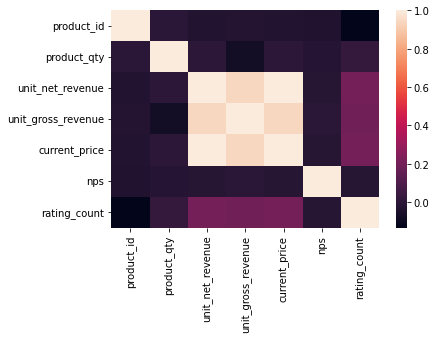

In [104]:
sns.heatmap(scaled_orders.corr())